# ECON 323 PROJECT

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
import folium
import rasterio
import geopandas as gpd
from plotnine import ggplot, aes, geom_line, geom_point, scale_x_continuous, labs, theme_538, geom_smooth
import statsmodels.api as sm
import ipywidgets as widgets
from IPython.display import display
#loading libraries

## Introduction


Sea level rise refers to an increase in the total volume of ocean water. It is caused by the melting of glaciers and the expansion of seawater as it warms, both of which result from climate change.

This rise poses a serious threat to coastal cities, where large population centers are often located. As water levels increase, urban infrastructure such as public transportation stations becomes more vulnerable to flooding and service interruptions. In the worst case scenario, they may be completely submerged. This is especially important in cities like Yokohama, Japan, much of which is built on reclaimed land just above sea level. In addition, its public transportation system relies on a complex and highly interconnected network, and losing one of the stations could disrupt service across multiple lines.

This project focuses on identifying gaps in the resilience of Yokohama’s railway stations to sea level rise. By mapping stations at risk of flooding and analyzing future vulnerabilities under different sea level scenarios, we aim to pinpoint areas with lack of insufficient connectivity and low elevation. The goal is to support planning efforts that maintain accessibility and ensure reliable transport despite the challenges posed by climate change.



## Data

This project employs data from three different sources. 

One of which is the using the The Sea Level Explorer Data to determine the sea level rise. The Sea Level Explorer was developed by NASA in collaboration with the United States Department of Defense, United States Department of State, and The World Bank. The Explorer delivers the latest information on past, present and future sea level change for every coastal country on Earth. 

Data Source: https://climateknowledgeportal.worldbank.org/download-data#htab-1503


Second, OpenStreepMap data was gathered using the osmnx library to obtain the geographic coordinates and names of railway stations. 


Lastly, the elevation digital dataset was retriced through the tessaDEM API to obtain the values for elevation for the region of interest. TessaDEM API merged and adjusted multiple sources according to tree height, urbanization and water presence using AW3D30, MERIT DEM, Forest Height, World Settlement Footprint and Global Surface Water. 




### Sea Level Rise

First we will investigate the sea level rise via a time series graph in order to observe long term trends and patterns.

In [2]:
sea_level = pd.read_csv("sealevel_global_explorer_data_global.csv") #reading the csv file

sea_level.tail(5) #looking at the last 5 rows of the data

,global,Reconstruction Year,Reconstruction Obs,Satellite Altimetry Year,Satellite Altimetry,Quadratic Fit Year,Quadratic Fit,Units,Unnamed: 8,Process,"Percentage Contribution, 1993 to Present"
375,global,NaN,NaN,2024.2500,64.769484,2024.2500,64.127380,mm,NaN,NaN,NaN
376,global,NaN,NaN,2024.3334,68.718135,2024.3334,64.494394,mm,NaN,NaN,NaN
377,global,NaN,NaN,2024.4166,66.197490,2024.4166,64.861900,mm,NaN,NaN,NaN
378,global,NaN,NaN,2024.5000,66.281110,2024.5000,65.229910,mm,NaN,NaN,NaN
379,global,NaN,NaN,2024.5834,66.425370,2024.5834,65.598410,mm,NaN,NaN,NaN


In [3]:
sea_level_filtered = sea_level[["Satellite Altimetry Year", "Satellite Altimetry"]] #select only the columns we need
sea_level_filtered = sea_level_filtered.rename(columns={"Satellite Altimetry Year": "Year", "Satellite Altimetry": "Sea Level (mm)"}) #renaming the column names to make them more readable
sea_level_filtered.head(5) #looking at the first 5 rows of the filtered data

,Year,Sea Level (mm)
0,1993.0000,-45.957685
1,1993.0834,-37.973130
2,1993.1666,-41.054863
3,1993.2500,-38.158152
4,1993.3334,-41.667910


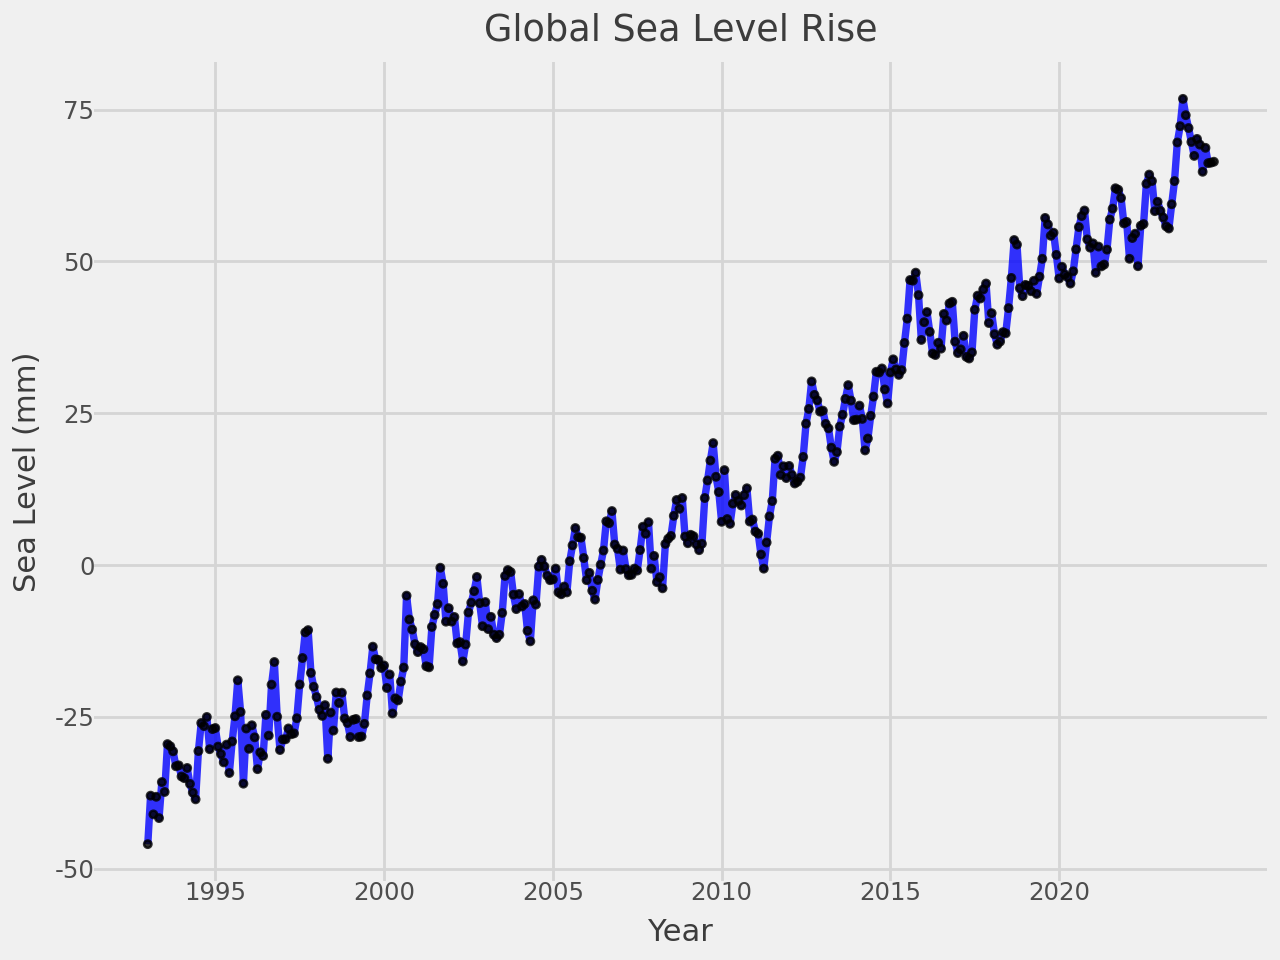

In [4]:
(
    ggplot(sea_level_filtered, aes(x="Year", y="Sea Level (mm)"))
    + geom_line(color='blue', size = 1.5, alpha = 0.8) #line to connect every point
    + geom_point(color='black', size = 1, alpha = 0.8) #data points
    + labs(
        title="Global Sea Level Rise",
        x="Year",
        y="Sea Level (mm)"
    ) #labels
    + scale_x_continuous(breaks=range(1880, 2025, 5))  # Tick every 5 years
    + theme_538()
)



Based on this graph, we can determine the overall trend in sea level. It appears to have risen steadily since the early 1990s, increasing from just below -50 mm to approximately 65 mm by mid 2024. There also appears to be some variation within in year, which could reflect seasonal fluctuations that could be possibly due to thermal expansion, melting patterns, or changes in widn that cause certain months or seasons to exhibit higher sea levels than others.

Overall, it is evident that sea level rise poses a significant concern for low lying coastal cities.


## Yokohama

Following this, we will look at the railway stations within Yokohama using the osmnx library

In [5]:



place_name = "Yokohama, Japan" #place name for the map

tags = {'railway': ['station']} #tags for the map


pt_stops = ox.features_from_place(place_name, tags=tags) #using placename and tags, retrieve data of railway stations


G_walk = ox.graph_from_place(place_name, network_type="walk") #retrieve data of all street network 


edges = ox.graph_to_gdfs(G_walk, nodes=False, edges=True) #convert G_walk data into edges for visualization




In [6]:
pt_stops

geometry   name  \
element id                                                                      
node    172522965                           POINT (139.65416 35.48688)    新子安   
        263267206                           POINT (139.53143 35.35431)     大船   
        263271899                           POINT (139.64512 35.48464)     子安   
        263274493                              POINT (139.64 35.48143)  神奈川新町   
        263274999                            POINT (139.6232 35.46621)     横浜   
...                                                                ...    ...   
        11329681981                         POINT (139.61742 35.50723)    新横浜   
        12209234608                         POINT (139.49383 35.53209)    長津田   
        12209234609                         POINT (139.49393 35.53191)    長津田   
way     183535997    POLYGON ((139.5183 35.4057, 139.51828 35.40568...    踊場駅   
        267917213    POLYGON ((139.49971 35.41434, 139.49975 35.414...    立場駅   

                                name:en name:ja name:ja_kana  \
element id                                                     
node    172522965           Shin-Koyasu     新子安        しんこやす   
        263267206                 Ōfuna     NaN          NaN   
        263271899                Koyasu      子安          こやす   
        263274493    Kanagawa-shimmachi   神奈川新町     かながわしんまち   
        263274999              Yokohama      横浜          NaN   
...                                 ...     ...          ...   
        11329681981       Shin-Yokohama     新横浜       しんよこはま   
        12209234608           Nagatsuta     長津田          NaN   
        12209234609           Nagatsuta     長津田          NaN   
way     183535997                   NaN     NaN          NaN   
        267917213                   NaN     NaN          NaN   

                             name:ja_rm  name:ko    name:ru  \
element id                                                    
node    172522965           Shin-Koyasu     신코야스  Син-Коясу   
        263267206                   NaN      NaN      Офуна   
        263271899                Koyasu      고야스        NaN   
        263274493    Kanagawa-shimmachi  가나가와신마치        NaN   
        263274999                   NaN     요코하마        NaN   
...                                 ...      ...        ...   
        11329681981       Shin-Yokohama      NaN        NaN   
        12209234608                 NaN     나가쓰다   Нагацута   
        12209234609                 NaN     나가쓰다   Нагацута   
way     183535997                   NaN      NaN        NaN   
        267917213                   NaN      NaN        NaN   

                                        operator public_transport  ...  \
element id                                                         ...   
node    172522965                        東日本旅客鉄道          station  ...   
        263267206                            NaN          station  ...   
        263271899                         京浜急行電鉄          station  ...   
        263274493    京浜急行電鉄 (Keikyu Corporation)          station  ...   
        263274999                         京浜急行電鉄          station  ...   
...                                          ...              ...  ...   
        11329681981                          NaN          station  ...   
        12209234608                       横浜高速鉄道          station  ...   
        12209234609                       東京急行電鉄          station  ...   
way     183535997                            NaN          station  ...   
        267917213                            NaN          station  ...   

                    baby_feeding operator:type operator:wikidata layer line  \
element id                                                                    
node    172522965            NaN           NaN               NaN   NaN  NaN   
        263267206            NaN           NaN               NaN   NaN  NaN   
        263271899            NaN           NaN               NaN   NaN  NaN 

In [7]:
list(pt_stops.columns.values) #list all column names to select only the ones we need

['geometry',
 'name',
 'name:en',
 'name:ja',
 'name:ja_kana',
 'name:ja_rm',
 'name:ko',
 'name:ru',
 'operator',
 'public_transport',
 'railway',
 'wikidata',
 'wikipedia',
 'KSJ2:LIN',
 'KSJ2:STN',
 'name:de',
 'name:fr',
 'name:it',
 'name:ja-Hira',
 'name:ja-Latn',
 'gauge',
 'name:es',
 'operator:en',
 'operator:ja',
 'ref',
 'source',
 'source_ref',
 'note',
 'contact:website',
 'name:ja-Kana',
 'wheelchair',
 'train',
 'name:zh-Hans',
 'wikimedia_commons',
 'light_rail',
 'station',
 'alt_name:ko',
 'network',
 'network:en',
 'network:ja',
 'network:wikidata',
 'subway',
 'KSJ2:RAS',
 'KSJ2:segment',
 'note:ja',
 'platforms',
 'website',
 'alt_name',
 'highspeed',
 'name:uk',
 'toilets:wheelchair',
 'phone',
 'air_conditioning',
 'internet_access',
 'start_date',
 'name:kr',
 'name:zh',
 'wikipedia:en',
 'baby_feeding',
 'operator:type',
 'operator:wikidata',
 'layer',
 'line',
 'fixme',
 'old_name',
 'alt_name:en',
 'building',
 'building:levels']

In [8]:
pt_stops_points = pt_stops[pt_stops.geometry.geom_type == "Point"] #select only the points geometry type from data

pt_stops_filtered = pt_stops_points[["geometry", "name","name:en","public_transport","operator"]] #select only the relevant columns

pt_stops_filtered = pt_stops_filtered.drop_duplicates(subset = ["name"]) #drop duplicates
#Since multiple railway companies can operate in the same station, we will keep only the first one


pt_stops_filtered

geometry     name             name:en  \
element id                                                                     
node    172522965    POINT (139.65416 35.48688)      新子安         Shin-Koyasu   
        263267206    POINT (139.53143 35.35431)       大船               Ōfuna   
        263271899    POINT (139.64512 35.48464)       子安              Koyasu   
        263274493       POINT (139.64 35.48143)    神奈川新町  Kanagawa-shimmachi   
        263274999     POINT (139.6232 35.46621)       横浜            Yokohama   
...                                         ...      ...                 ...   
        8026433198   POINT (139.68939 35.49574)      弁天橋         Bentembashi   
        8026435189    POINT (139.6754 35.50098)       国道              Kokudo   
        8317640068   POINT (139.48649 35.55813)    こどもの国        Kodomonokuni   
        10108140342   POINT (139.6361 35.53585)      新綱島     Shin-Tsunashima   
        10312940095   POINT (139.5896 35.48341)  横浜羽沢（貨）                 NaN   

                    public_transport                     operator  
element id                                                         
node    172522965            station                      東日本旅客鉄道  
        263267206            station                          NaN  
        263271899            station                       京浜急行電鉄  
        263274493            station  京浜急行電鉄 (Keikyu Corporation)  
        263274999            station                       京浜急行電鉄  
...                              ...                          ...  
        8026433198           station                      東日本旅客鉄道  
        8026435189           station                      東日本旅客鉄道  
        8317640068           station                         東急電鉄  
        10108140342          station                          NaN  
        10312940095          station                          NaN  

[140 rows x 5 columns]

In [9]:

pt_stops_filtered.to_csv("pt_stops_yokohama.csv", index = False)
#this can be ignored, it was used so I can manually view the data via csv file and not in the notebook

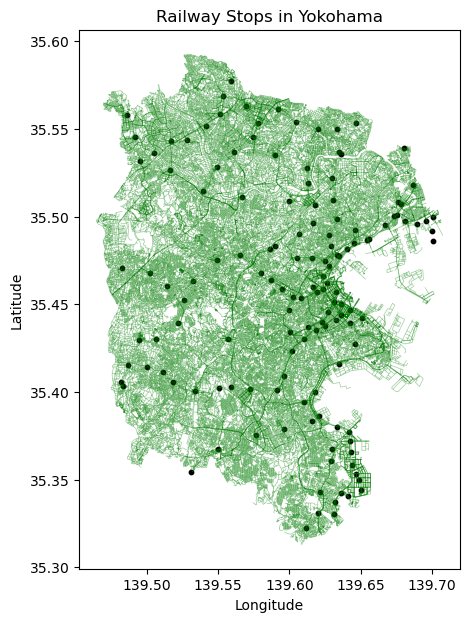

In [10]:

fig, ax = plt.subplots(figsize=(7,7))

edges.plot(ax=ax, color="green", linewidth=0.5, alpha=0.2) #plot the street network

pt_stops_filtered.plot(ax=ax, color="black", markersize=10) #plot the railway station


plt.title("Railway Stops in Yokohama")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")#set axis labels
plt.show()

fig.savefig("pt_stops_yokohama.png")

Evidently, based on the graph, the railway transport network is rather expansive. However, most of them lie just beside the coast. It's not easily visible on this map but it is on the right hand side of where the majority of stations are located. In contrast, the left side seems to be more sparse, likely due to mountainous terrain or lower population density. This pattern is also reflected in the street network, which is denser on the right side compared to the left.

A secondary purpose of this graph is to clearly define the area covered by Yokohama, as this may become less apparent in later visualizations.

### Yokohama and Sea Level

Following this, the elevation will be incorportared into the graph. The elevation is retrieved via an the TessaDEM API. It is included in the markdown because the actual call was made on a secondary file with the API key included. 


```python
# set the area of Yokohama
lat_min, lon_min = 35.3, 139.45 
lat_max, lon_max = 35.6, 139.75 


url = (f"https://tessadem.com/api/elevation?key={API_KEY}&mode=area&rows=128&columns=128&locations={lat_min},{lon_min}|{lat_max},{lon_max}&format=geotiff") #using the API with the set boundaries. 

#sent the request to the url
response = requests.get(url)

#save it as a GeoTiff file
with open("yokohama_elevation_corrected.tif", "wb") as my_file:
    my_file.write(response.content)
```


With the new elevation data, we can visualize the elevation as a background layer to provide context for the location of railway stations.

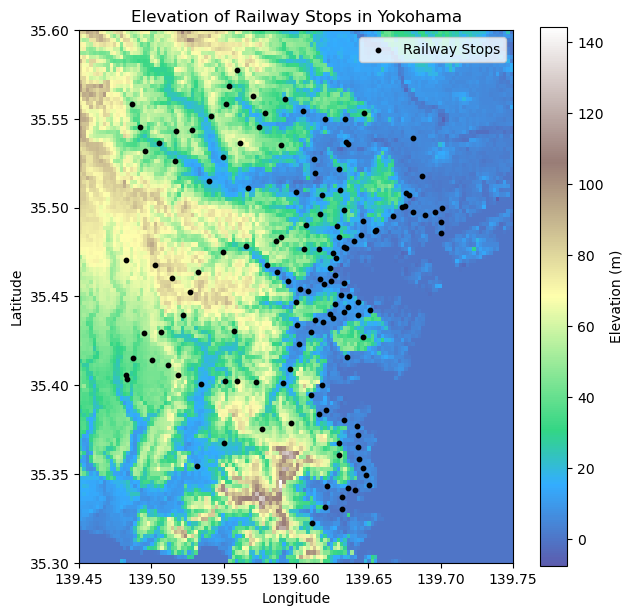

In [11]:
elevation_src = rasterio.open("yokohama_elevation_corrected.tif") #load the elevation data
elevation = elevation_src.read(1) #read the elevation data as a numpy array
bounds = elevation_src.bounds #get the bound of elevation data 


fig, ax = plt.subplots(figsize=(7,7))

#Display the elevation data using a terrain colormap
im = ax.imshow(
    elevation,
    cmap="terrain", 
    extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
    alpha=0.8 
)

#plot the railway stops
pt_stops_filtered.plot(ax=ax, color="black", markersize=10, label="Railway Stops")

#labels and legend
ax.set_title("Elevation of Railway Stops in Yokohama")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

plt.colorbar(im, ax=ax, label="Elevation (m)") #add the colorbar to show elevation values
plt.show()

fig.savefig("combined_yokohama_elevation_pt.png")

This graph gives a better idea of stations that are at risk of sea level rise. Most of the seem to lie between 10 and 0 metres around the coastline the the right hand side. In contrast, the left side of the map, which features higher terrain shown in green and yellow shades, contains significantly fewer railway stations. This difference is likely due to the more rugged, mountainous terrain in those areas, which makes railway construction and urban development more challenging.

The visualization also highlights the structure of Yokohama’s rail network, with many stations following a linear path from north to south or south to north depending on the perspective. This likely reflects the presence of key railway lines that run along relatively flat coastal terrain. In addition, north of Yokohama is Tokyo, and many of these lines running from south to north go directly to Tokyo, reinforcing their importance as commuter routes. With most of these stations in low elevation areas, the graph highlights how vulnerable key stations may be affected by sea level rise.

While the previous visualization of provides general idea of the elevations of each area, it does not give the exact elevation of each station. Therefore, foilum will be used to create a interactive map with each station labelled with names and the elevation.


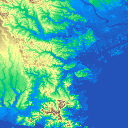

In [12]:
plt.imsave("elevation_overlay.png", elevation, cmap='terrain') #save the elevation data as an image for folium map


interactive_map = folium.Map(location=[35.5, 139.6], zoom_start=12.5) #initialize the folium map

# add the elevation overlay to the map
folium.raster_layers.ImageOverlay(
    name="Elevation",
    image="elevation_overlay.png",
    bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
    opacity=0.7,
).add_to(interactive_map)


coords = [(point.y, point.x) for point in pt_stops_filtered.geometry] #extract the coordinates of the railway stops

pt_stops_filtered["elevation"] = [x[0] for x in elevation_src.sample([(lon, lat) for lat, lon in coords])] 
#add elevation data to pt_stops_filtered by sampling the elevation data at the coordinates of the railway stops


# add a circle marker for each station with popup information
for _, row in pt_stops_filtered.iterrows():
    station_name = row.get("name")
    station_name_en = row.get("name:en")
    elevation_value = row["elevation"]

    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=4,
        color="black",
        fill=True,
        fill_opacity=0.9,
        popup=folium.Popup(
            f"<b>{station_name}</b><br><i>{station_name_en}</i><br>Elevation: {elevation_value:.1f} m")
    ).add_to(interactive_map)

folium.LayerControl().add_to(interactive_map) #add layer control toggle



interactive_map

To predict the rise in sea level in the future, OLS will be used. 
Sea level is modeled as:

$$
\text{Sea Level} = \beta_0 + \beta_1 \cdot \text{Year}
$$

In this model, the intercept $\beta_0$ represents the estimated sea level at year zero, while the slope $\beta_1$ represents the average annual change in sea level. A positive $\beta_1$ would indicate a rising trend. Once the model is fitted using historical sea level data, future values can be predicted by plugging in future years as inputs.

Before making predictions, the historical sea level data will be overlaid with a linear regression line to assess whether a linear model was a reasonable fit. The relatively stable linear relationship between year and sea level suggests that Ordinary Least Squares (OLS) regression can serve as a reasonable first approximation for forecasting future sea level values.

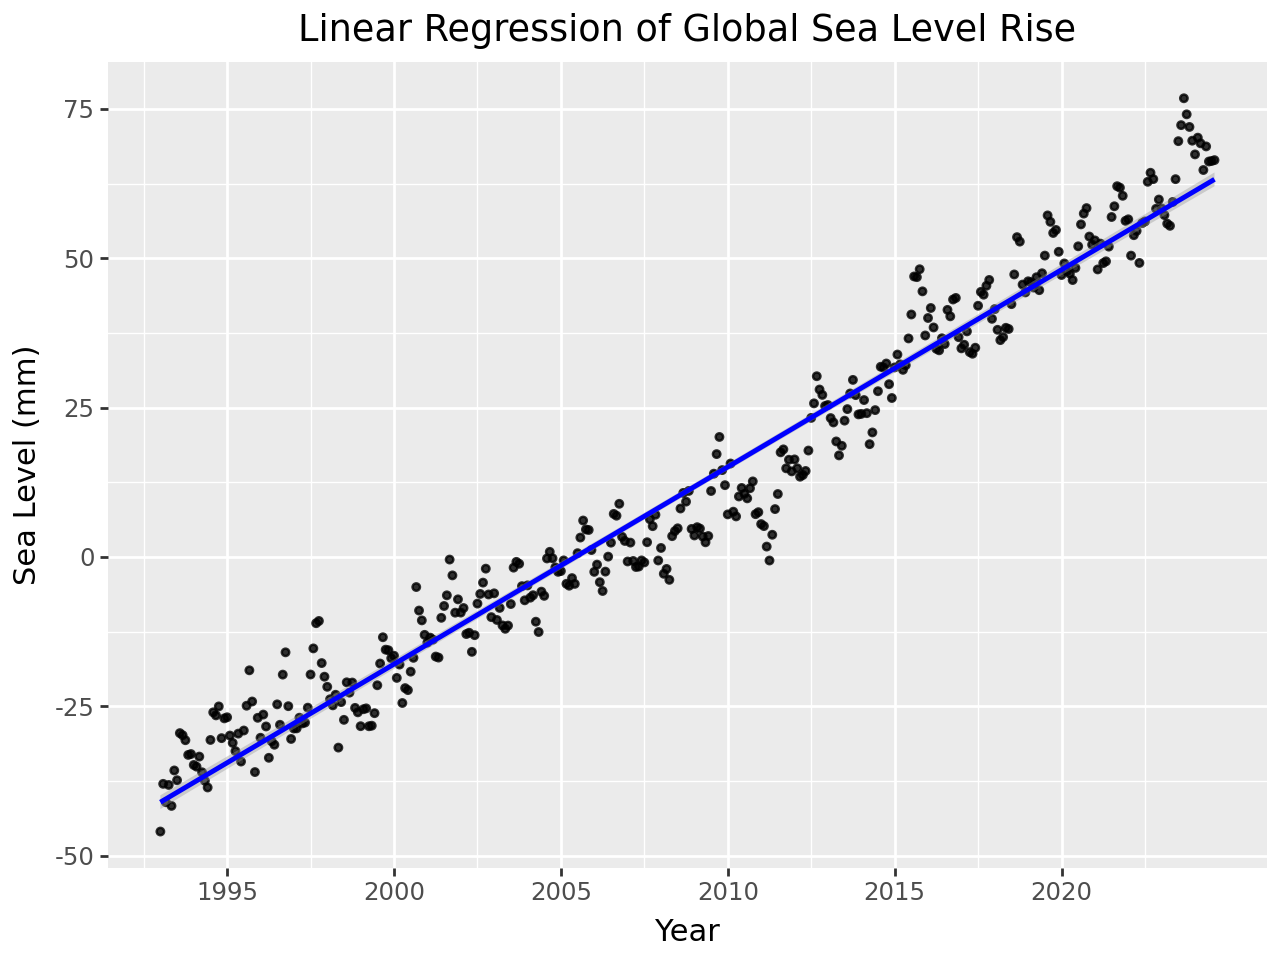

In [13]:
(
    ggplot(sea_level_filtered, aes(x="Year", y="Sea Level (mm)"))
    + geom_point(color='black', size = 1, alpha = 0.8)
    + geom_smooth(method="lm", color="blue")
    + labs(title = "Linear Regression of Global Sea Level Rise", x="Year", y="Sea Level (mm)")
    + scale_x_continuous(breaks=range(1880, 2025, 5))  # Tick every 5 years

)



In [14]:

x = sea_level_filtered["Year"].values #convert to array
y = sea_level_filtered["Sea Level (mm)"].values #convert to array

# Add constant for intercept term
x_sm = sm.add_constant(x)

# Fit the OLS model
model = sm.OLS(y, x_sm)
results = model.fit()


print(results.summary())



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                 1.046e+04
Date:                Mon, 14 Apr 2025   Prob (F-statistic):          1.37e-277
Time:                        23:55:58   Log-Likelihood:                -1202.9
No. Observations:                 380   AIC:                             2410.
Df Residuals:                     378   BIC:                             2418.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6619.7796     64.825   -102.117      0.0

Each additional year is associated with a 3.3009 mm increase in the sea level. This value is also statistically significant at a 95% confidence level, confirming the consistent upward trend in global sea level over time. 

$\beta_0$ should not be interpreted, as it falls significantly outside the range of the observed years and does not correspond to a meaningful value. 

The model also has a high R squared of 0.965 which means that it explains 96.5% of the variation in the model. This suggests that the model is a reasonable approximation for and predicting sea level trend. 

However, it is worth noting that the Durbin Watson correlation is quite low, compared to the optimal 2.0. This suggests that there might be some auto correlation present within the residuals, which is common in in the series data. 

Following this the model will be used to make future prediction on sea level rise.

In [15]:
# Predict for future years up till 2500
future_years = np.arange(2025, 2501, 25)
future_x_sm = sm.add_constant(future_years)  # Add intercept

# Get predictions
future_preds = results.predict(future_x_sm)

# Create DataFrame of predictions
future_df = pd.DataFrame({"Year": future_years, "Predicted Sea Level (mm)": future_preds})

future_df

,Year,Predicted Sea Level (mm)
0,2025,64.582660
1,2050,147.105651
2,2075,229.628641
3,2100,312.151632
4,2125,394.674622
5,2150,477.197612
6,2175,559.720603
7,2200,642.243593
8,2225,724.766584
9,2250,807.289574


In [16]:
#subtract by the 1st year (current) to get the sea level change
future_df["Predicted Sea Level (mm)"] = future_df["Predicted Sea Level (mm)"] - future_df["Predicted Sea Level (mm)"].min() 

future_df["Predicted Sea Level (mm)"] = future_df["Predicted Sea Level (mm)"] / 1000 #convert to meters 


future_df = future_df.rename(columns={"Predicted Sea Level (mm)": "Predicted Sea Level Change (m)"}) #rename column to meters
future_df = future_df[["Year", "Predicted Sea Level Change (m)"]] #select the columns

future_df

,Year,Predicted Sea Level Change (m)
0,2025,0.000000
1,2050,0.082523
2,2075,0.165046
3,2100,0.247569
4,2125,0.330092
5,2150,0.412615
6,2175,0.495138
7,2200,0.577661
8,2225,0.660184
9,2250,0.742707


In [18]:


# Create a new DataFrame with the future years and their corresponding sea level changes
elevation_src = rasterio.open("yokohama_elevation_corrected.tif")
elevation_base = elevation_src.read(1)
bounds = elevation_src.bounds
extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]



# Create a slider for the years
slider = widgets.SelectionSlider(
    options=future_df['Year'].tolist(),
    value=2025,
    description='Year:',
    continuous_update=False
)


# Function to update the map based on the selected year
def updates_map(year):
    sea_level_m = future_df.loc[future_df['Year'] == year, 'Predicted Sea Level Change (m)'].values[0]
    #Subtract the elevation by the increase in sea level, this should change the color of the map as well
    adjusted_elevation = elevation_base - sea_level_m 
    fig, ax = plt.subplots(figsize=(7, 7)) 

    # Lock color scale across all years to visualize rising sea level
    im = ax.imshow(
        adjusted_elevation,
        cmap="terrain",
        extent=extent,
        alpha=0.8,
        vmin=-10,  # anything ≤ 0 will appear darker
        vmax=np.max(elevation_base)
    )

    #Categorize stations by their elevation relative to sea level
    elevations = pt_stops_filtered["elevation"]
    submerged = pt_stops_filtered[elevations - sea_level_m < 0]
    at_risk = pt_stops_filtered[(elevations - sea_level_m >= 0) & (elevations - sea_level_m < 2.5)]
    safe = pt_stops_filtered[elevations - sea_level_m >= 2.5]

    # Plot stations by by whther they are submerged, at risk, or safe
    if not safe.empty:
        safe.plot(ax=ax, color="black", markersize=10, label="Safe (≥ 2.5m)")
    if not at_risk.empty:
        at_risk.plot(ax=ax, color="yellow", markersize=10, label="At Risk (< 2.5m)")
    if not submerged.empty:
        submerged.plot(ax=ax, color="red", markersize=10, label="Submerged (< 0m)")

    #Add labels
    ax.set_title(f"Year: {year} | Sea Level: {sea_level_m:.2f} m")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()
    plt.colorbar(im, ax=ax, label="Elevation (m) relative to sea level")
    plt.show()



# create the widget and display the map
widgets.interact(updates_map, year=slider)


interactive(children=(SelectionSlider(continuous_update=False, description='Year:', options=(2025, 2050, 2075,…

<function __main__.updates_map(year)>

Using this visualization we can determine the stations submerged (less than 0 meters) or at risk (between 0 meters and 2.5 meters) or safe (bigger than 2.5 meters). Based on the graph we can see that in the base year, one station, Hakkeijima, is at risk of being submerged. The name directly translates to Eight Scenic Island, which makes sense given its coastal location. Fortunately, no other stations appear to be immediately at risk at this time.

By the year 2100, it becomes evident that Hakkeijima has been submerged, and a second station, Nojimakoen, now falls within the at-risk elevation range.

By 2200 4 new stations become vulnerable to sea level rise and by 2500 there are 10 stations at risk of being submerged. 

This pattern highlights an acceleration of risk over time, reflecting the compounding nature of sea level rise. While early effects are limited to a few low lying areas, the effects in the later years show a growing number of stations impacted. In addition, it also makes these areas particularly susceptible to flooding and tsunamis.

This visualisation emphasizes the need for forward looking infrastructure planning and mitigation of climate change effects in Yokohama. Stations that are currently safe may become vulnerable in the future, and may require relocation of key parts of the railway network.

It is also worth noting that although the elevation raster is adjusted to include sea level rise, the actual changes are relatively small compared to the overall difference in elevation. Thus, the changes in terrain color across years may not be visually apparent, even if the elevation values were adjusted. 


## Conclusion


In conclusion, the project highlights that Yokohama is prone to sea level rise, with several stations projected to be at risk or completely submerged in the following centuries. As climate change continues to worsen, the existing infrastructue will face increasing threats. These findings emphasizes implementing climate adaptation and mitigation strategies, and long term urban planning to protect infrastructure and improve resilience. 

One limitation is that this model assumes the historical trend will continue, but this may not hold. Many climate models suggests accelerated sea level rise, especially after 2100. This suggests that perhaps a polynomial or exponential model may be able to capture and predict the trend better. The current linear model largely underestimates projections made by IPCC , or other climate research, which may include non linear and policy sensitive projections (Moore, 2019). Therefore, even if the current R squared is strong, it is likely conservative in the long term projections that have been made with the linear model. 

Another limitation could be that the elevation values captured co uld be inaccurate including buildings. The elevation values may not be precise enough to pinpoint the elevation at the exact location of the station. This is included the the TessaDEM disclaimer "Data accuracy cannot be guaranteed as the presence of buildings, steep slopes and other artefacts may alter spaceborne readings". As a result, some stations may appear safer or more at risk than they truly are, introducing potential errors in the risk classification.

Future research could consider implementing a polynomial model or time series model for better prediction. Addtionally, incorporating multiple predictors could also make the model more robust. 

## References

Climate Change Knowledge Portal. (2024). Homepage | World Bank Climate Change Knowledge Portal. Worldbank.org. https://climateknowledgeportal.worldbank.org/

Moore, R. (2019, September 25). IPCC Report: Sea Level Rise Is a Present and Future Danger. Www.nrdc.org. https://www.nrdc.org/bio/rob-moore/ipcc-report-sea-level-rise-present-and-future-danger

TessaDEM: Near-global 30-meter Digital Elevation Model (DEM). (n.d.). Tessadem.com. https://tessadem.com/